<a href="https://colab.research.google.com/github/thaisflopes/modelo-de-classificacao-de-churn-de-clientes-de-um-banco/blob/main/modelo_de_classificacao_de_churn_de_clientes_de_um_banco.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Informações Iniciais

Descrição: Trata-se de um projeto para criação de um modelo de classificação de churn de clientes de um banco, em que foram comparados dois modelos, um de SVM e outro de KNN. Também foi trabalhado um problema de desbalanceamento das classes, com aplicação da técnica undersampling. 

Projeto desenvolvido na disciplina Fundamentos da Mineração de Dados (Data Mining).

Elaborado em 09/10/2020 por Thaís Lopes (https://github.com/thaisflopes)
___

## Contexto

Churn, também conhecido como churn rate, é um indicador que mede o índice de evasão dos clientes, ou seja, a taxa de cancelamento de um serviço. 

Nesse projeto será analisado um conjunto de dados a respeito do churn de clientes de um banco. **O objetivo é criar um modelo de classificação de churn de clientes** com o intuito de que, no futuro, o banco consiga classificá-los, a partir de padrões observados em casos anteriores, antes que tomem essa decisão para prevenir que a realizem.

Do ponto de vista financeiro de uma empresa é mais caro conseguir um novo cliente do que manter um existente, assim, saber o que leva o cliente a decidir deixar a empresa é vantajoso, pois com essa informação ela pode prevenir o churn por meio do desenvolvimento de programas de fidelidade, campanhas de retenção, entre outras ações.

Dessa forma, esse projeto está dividido em três partes:
1. A primeira consiste na análise exploratória dos dados;
2. A segunda consiste no treinamento de um modelo; e
3. A terceira consiste na validação do modelo proposto.

## 1. Análise exploratória

### 1.1. Instalando as bibliotecas

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns #visualisação                   
import matplotlib.pyplot as plt #visualisação             
%matplotlib inline     
sns.set(color_codes=True)

### 1.2. Carregando os dados

Como informado no Contexto, nesse projeto será usado um dataset de [churn de clientes de um banco disponibilizado no Kaggle](https://www.kaggle.com/mathchi/churn-for-bank-customers).

Os códigos a seguir baixam o arquivo para dentro do ambiente do Colab. O arquivo está no Google Drive e foi compartilhado através de um link público. 

In [ ]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [ ]:
file_dir = 'data_churn_for_bank_customers' #nome do arquivo zip
filename = file_dir + '.zip'

In [ ]:
downloaded = drive.CreateFile({'id':"12fVDxaTEV_JaxMY-oEFd7eQzoW1SWETp"}) #id do arquivo zip
downloaded.GetContentFile('data_churn_for_bank_customers.zip') #nome do arquivo zip    

O código seguinte descompacta o arquivo para dentro do diretório que será utilizado como fonte de dados.

In [ ]:
print(filename)

# Unzip
import zipfile
import os.path
import pathlib

zip_ref = zipfile.ZipFile(filename, 'r')
zip_ref.extractall(file_dir)
zip_ref.close()

this_dir = pathlib.Path().absolute()

filepath = os.path.join(os.path.join(this_dir, file_dir), "churn.csv") #nome da planilha csv
print(filepath)

data_churn_for_bank_customers.zip
/content/data_churn_for_bank_customers/churn.csv


In [ ]:
dados = pd.read_csv(filepath)

# Para visualizar as 5 primeiras linhas
dados.head(5)               

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In [ ]:
# Para visualizar as 5 últimas linhas
dados.tail(5)                        

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
9995,9996,15606229,Obijiaku,771,France,Male,39,5,0.00,2,1,0,96270.64,0
9996,9997,15569892,Johnstone,516,France,Male,35,10,57369.61,1,1,1,101699.77,0
9997,9998,15584532,Liu,709,France,Female,36,7,0.00,1,0,1,42085.58,1
9998,9999,15682355,Sabbatini,772,Germany,Male,42,3,75075.31,2,1,0,92888.52,1
9999,10000,15628319,Walker,792,France,Female,28,4,130142.79,1,1,0,38190.78,0


### 1.3. Verificando os tipos de dados

A seguir, foram verificados os tipos de dados presentes no dataset, para facilitar a identificação dos algoritmos que podem ser aplicados a ele.


In [ ]:
dados.dtypes

RowNumber            int64
CustomerId           int64
Surname             object
CreditScore          int64
Geography           object
Gender              object
Age                  int64
Tenure               int64
Balance            float64
NumOfProducts        int64
HasCrCard            int64
IsActiveMember       int64
EstimatedSalary    float64
Exited               int64
dtype: object

Observa-se que a maioria dos dados são numéricos, porém três são categóricos.










### 1.4. Removendo dados irrelevantes

Além de identificar os tipos de dados, deve-se saber também o que cada variável significa e se ela pode ou não ter relação com a pergunta do projeto. A seguir estão apresentadas essas informações:

* **RowNumber:** corresponde ao número do registro (linha) - não tem efeito sobre a saída do cliente;
* **CustomerId:** contém valores aleatórios de identificação do cliente - não tem efeito sobre a saída do cliente;            
* **Surname:** corresponde ao sobrenome de cada cliente - também não afeta sua decisão de deixar o banco;
* **CreditScore:** pontuação de crédito do cliente - pode ter efeito na rotatividade do cliente, visto que um cliente com uma pontuação de crédito mais alta tem menos probabilidade de deixar o banco;
* **Geography:** localização de um cliente - pode afetar sua de decisão de deixar o banco;
* **Gender:** gênero do cliente - é interessante analisar se o gênero tem alguma relação com a saída do cliente do banco;   
* **Age:** idade - é relevante, visto que que clientes mais velhos têm menos probabilidade de sair do banco do que os mais jovens;   
* **Tenure:** número de anos que o cliente é cliente do banco - é relevante, visto que normalmente os clientes mais antigos são mais leais e menos propensos a deixar um banco;         
* **Balance:** saldo - também um bom indicador de rotatividade de clientes, já que as pessoas com um saldo mais alto em suas contas têm menos probabilidade de deixar o banco em comparação com aquelas com saldos mais baixos;
* **NumOfProducts:** número de produtos que um cliente comprou por meio do banco - pode ser analisado se a quantidade de produtos tem relação com a saída ou não do cliente;
* **HasCrCard:** informa se o cliente tem ou não um cartão de crédito - é relevante, uma vez que pessoas com cartão de crédito têm menor probabilidade de sair do banco;
* **IsActiveMember:** informa se o cliente é ativo ou não - é relevante, visto que os clientes ativos têm menos probabilidade de sair do banco;    
* **EstimatedSalary:** salário estimado - assim como ocorre com o saldo, as pessoas com salários mais baixos têm maior probabilidade de deixar o banco em comparação com aquelas com salários mais altos;
* **Exited:** informa os clientes que saíram ou não do banco.

Como os dados RowNumber, CustomerId e Surname não são úteis para a análise, eles serão retirados.


In [ ]:
dados = dados.drop(['RowNumber', 'CustomerId', 'Surname'], axis=1)
dados.head(5)

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


### 1.5. Tratando dados categóricos

Após retirar os dados irrelevantes, ainda existem dois dados categóricos (Geography e Gender). Para facilitar a utilização dos modelos, eles serão transformados em dados numéricos (Geography_num e Gender_num).   

In [ ]:
dados['Geography'].value_counts()

France     5014
Germany    2509
Spain      2477
Name: Geography, dtype: int64

In [ ]:
Geography_num = dados['Geography'].replace({'France' : 0, 'Germany' : 1, 'Spain' : 2})

In [ ]:
Geography_num.value_counts()

0    5014
1    2509
2    2477
Name: Geography, dtype: int64

In [ ]:
dados['Geography_num'] = Geography_num
dados.head()

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Geography_num
0,619,France,Female,42,2,0.00,1,1,1,101348.88,1,0
1,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0,2
2,502,France,Female,42,8,159660.80,3,1,0,113931.57,1,0
3,699,France,Female,39,1,0.00,2,0,0,93826.63,0,0
4,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0,2


In [ ]:
dados['Gender'].value_counts()

Male      5457
Female    4543
Name: Gender, dtype: int64

In [ ]:
Gender_num = dados['Gender'].replace({'Male' : 0, 'Female' : 1})

In [ ]:
Gender_num.value_counts()

0    5457
1    4543
Name: Gender, dtype: int64

In [ ]:
dados['Gender_num'] = Gender_num
dados.head()

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Geography_num,Gender_num
0,619,France,Female,42,2,0.00,1,1,1,101348.88,1,0,1
1,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0,2,1
2,502,France,Female,42,8,159660.80,3,1,0,113931.57,1,0,1
3,699,France,Female,39,1,0.00,2,0,0,93826.63,0,0,1
4,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0,2,1


In [ ]:
dados = dados.drop(['Geography', 'Gender'], axis=1)
dados

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Geography_num,Gender_num
0,619,42,2,0.00,1,1,1,101348.88,1,0,1
1,608,41,1,83807.86,1,0,1,112542.58,0,2,1
2,502,42,8,159660.80,3,1,0,113931.57,1,0,1
3,699,39,1,0.00,2,0,0,93826.63,0,0,1
4,850,43,2,125510.82,1,1,1,79084.10,0,2,1
...,...,...,...,...,...,...,...,...,...,...,...
9995,771,39,5,0.00,2,1,0,96270.64,0,0,0
9996,516,35,10,57369.61,1,1,1,101699.77,0,0,0
9997,709,36,7,0.00,1,0,1,42085.58,1,0,1
9998,772,42,3,75075.31,2,1,0,92888.52,1,1,0


### 1.6. Removendo linhas duplicadas

In [ ]:
dados.shape

(10000, 11)

In [ ]:
linhas_duplicadas_dados = dados[dados.duplicated()]
print("Número de linhas duplicadas: ", linhas_duplicadas_dados.shape)

Número de linhas duplicadas:  (0, 11)


O dataset não possui linhas duplicadas.



### 1.7. Eliminando os valores ausentes ou nulos

In [ ]:
print(dados.isnull().sum())

CreditScore        0
Age                0
Tenure             0
Balance            0
NumOfProducts      0
HasCrCard          0
IsActiveMember     0
EstimatedSalary    0
Exited             0
Geography_num      0
Gender_num         0
dtype: int64


O dataset também não possui dados ausentes.

### 1.8. Detecção de Outliers

É importante analisar se os dados possuem muitos *outliers* para definir o escopo de análises que poderão ser realizadas.
Dessa forma, a seguir serão análisados a distribuição dos dados das seguintes variáveis:
* CreditScore
* Age
* Tenure
* Balance
* NumOfProducts
* EstimatedSalary


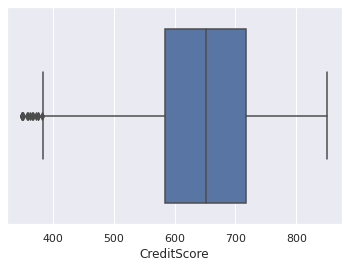

In [ ]:
sns.boxplot(x=dados['CreditScore'])

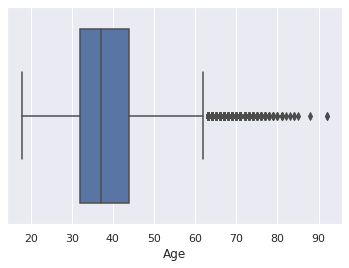

In [ ]:
sns.boxplot(x=dados['Age'])

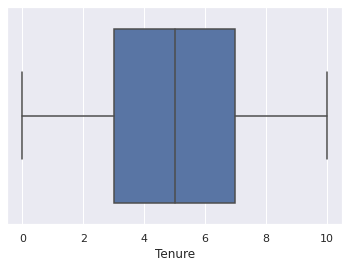

In [ ]:
sns.boxplot(x=dados['Tenure'])

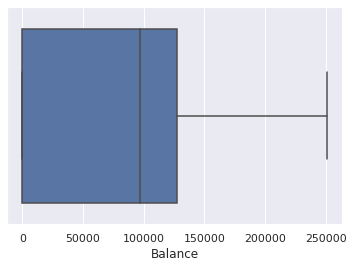

In [ ]:
sns.boxplot(x=dados['Balance'])

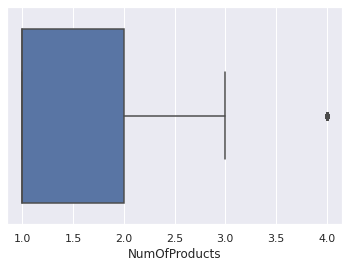

In [ ]:
sns.boxplot(x=dados['NumOfProducts'])

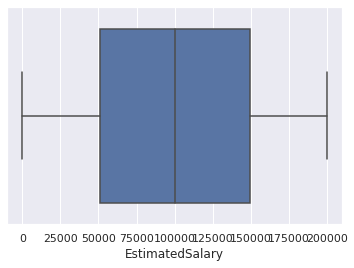

In [ ]:
sns.boxplot(x=dados['EstimatedSalary'])

Pelos gráficos acima, observa-se que apenas as variáveis CreditScore, Age e NumOfProducts apresentaram outliers. A seguir os outliers serão retirados da base.

In [ ]:
#Calculando os quantis inferiores e superiores
dados1 = dados.copy()
Q1 = dados1.quantile(0.25)
Q3 = dados1.quantile(0.75)
IQR = Q3 - Q1
print(IQR)

CreditScore           134.0000
Age                    12.0000
Tenure                  4.0000
Balance            127644.2400
NumOfProducts           1.0000
HasCrCard               1.0000
IsActiveMember          1.0000
EstimatedSalary     98386.1375
Exited                  0.0000
Geography_num           1.0000
Gender_num              1.0000
dtype: float64


In [ ]:
#Removendo os outliers presentes nos quantis inferiores e superiores
dados1 = dados1[~((dados1 < (Q1 - 1.5 * IQR)) |(dados1 > (Q3 + 1.5 * IQR))).any(axis=1)]
dados1.shape

(7677, 11)

In [ ]:
10000-7677

2323

Foram encontradas 2323 linhas que são possíveis *outliers*. Porém, ao analisar a quantidade de dados para a variável Exited, antes (dados_churn) e depois (dados_churn1) de tirar os outliers, observa-se que todos os valores de clientes que sairam do banco são eliminados. Sendo assim, a análise seguirá em cima da base de dados contendo os outliers para não perder a informação de churn.

In [ ]:
dados['Exited'].value_counts()

0    7963
1    2037
Name: Exited, dtype: int64

In [ ]:
dados1['Exited'].value_counts()

0    7677
Name: Exited, dtype: int64

### 1.9. Visualização dos dados

#### Mapa de calor

O mapa de calor auxilia a encontrar as variáveis que possuem correlação, identificando as análises que serão mais interessantes para o conjunto de dados.

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Geography_num,Gender_num
CreditScore,1.000000,-0.003965,0.000842,0.006268,0.012238,-0.005458,0.025651,-0.001384,-0.027094,0.007888,0.002857
Age,-0.003965,1.000000,-0.009997,0.028308,-0.030680,-0.011721,0.085472,-0.007201,0.285323,0.022812,0.027544
Tenure,0.000842,-0.009997,1.000000,-0.012254,0.013444,0.022583,-0.028362,0.007784,-0.014001,0.003739,-0.014733
Balance,0.006268,0.028308,-0.012254,1.000000,-0.304180,-0.014858,-0.010084,0.012797,0.118533,0.069408,-0.012087
NumOfProducts,0.012238,-0.030680,0.013444,-0.304180,1.000000,0.003183,0.009612,0.014204,-0.047820,0.003972,0.021859
HasCrCard,-0.005458,-0.011721,0.022583,-0.014858,0.003183,1.000000,-0.011866,-0.009933,-0.007138,-0.008523,-0.005766
IsActiveMember,0.025651,0.085472,-0.028362,-0.010084,0.009612,-0.011866,1.000000,-0.011421,-0.156128,0.006724,-0.022544
EstimatedSalary,-0.001384,-0.007201,0.007784,0.012797,0.014204,-0.009933,-0.011421,1.000000,0.012097,-0.001369,0.008112
Exited,-0.027094,0.285323,-0.014001,0.118533,-0.047820,-0.007138,-0.156128,0.012097,1.000000,0.035943,0.106512
Geography_num,0.007888,0.022812,0.003739,0.069408,0.003972,-0.008523,0.006724,-0.001369,0.035943,1.000000,-0.004719


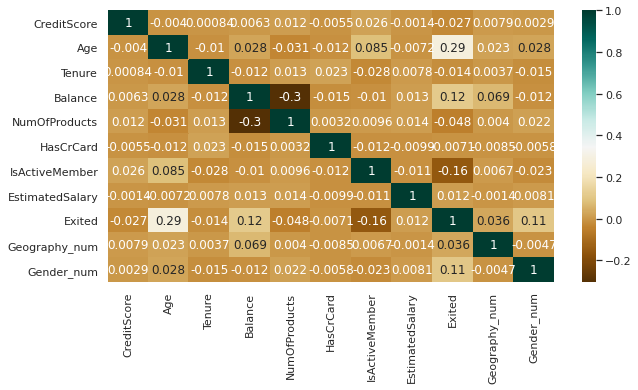

In [ ]:
plt.figure(figsize=(10,5))
c= dados.corr()
sns.heatmap(c,cmap="BrBG",annot=True)
c

Observa-se no mapa de calor que a correlação entre as variáveis são baixas, sendo as maiores igual a:

* Exited e Age - Correlação: 0,29 
* Exited e Balance - Correlação: 0,12 
* Exited e Gender_num - Correlação: 0,11
* IsActiveMember e Age - Correlação: 0,085
* Geography_num e Balance - Correlação: 0,069
* Exited e Geography_num - Correlação: 0,036
* Exited e EstimatedSalary - Correlação: 0,012

Assim, os gráficos a seguir são para tentar encontrar padrões entre as variáveis e a saída ou não do cliente do banco.

/usr/local/lib/python3.6/dist-packages/seaborn/axisgrid.py:316: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/axisgrid.py:645: UserWarning: Using the countplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


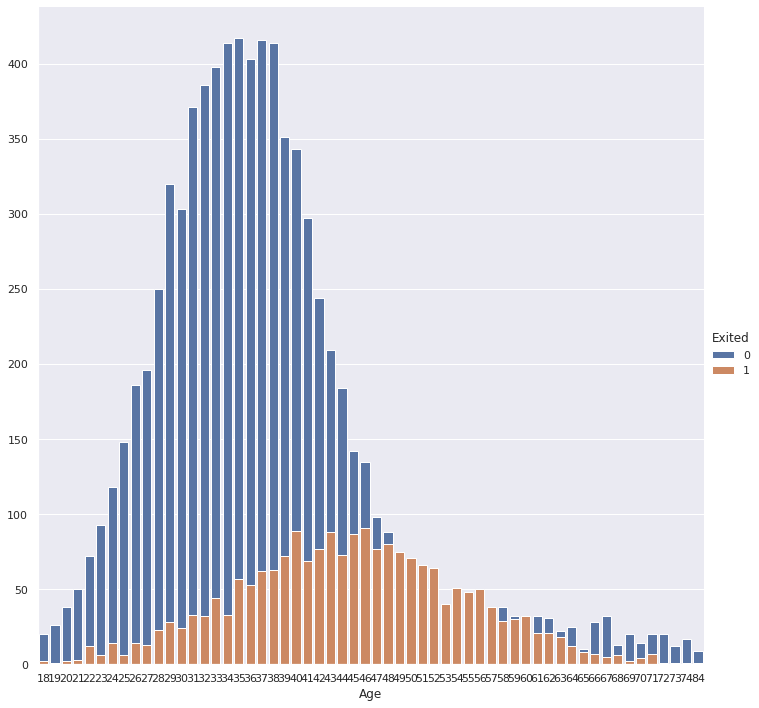

In [ ]:
#Exited e Age - Correlação: 0,29
g = sns.FacetGrid(dados, hue='Exited', size=10)
g.map(sns.countplot, 'Age')
g.add_legend()

Observa-se que a maior parte de clientes do banco tem entre 26 a 44 anos e, dos que sairam, a maioria está entre 37 a 52 anos.

/usr/local/lib/python3.6/dist-packages/seaborn/axisgrid.py:316: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


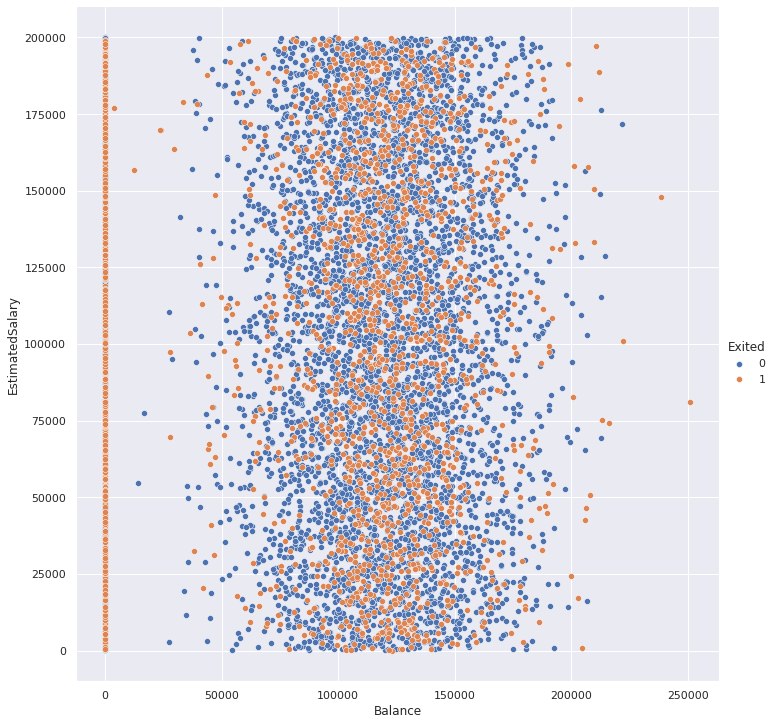

In [ ]:
#Exited e Balance - Correlação: 0,12
#Exited e EstimatedSalary - Correlação: 0,012
g = sns.FacetGrid(dados, hue="Exited", size=10)
g.map_dataframe(sns.scatterplot, x="Balance", y="EstimatedSalary")
g.set_axis_labels("Balance", "EstimatedSalary")
g.add_legend()

Obseva-se que muitos clientes que sairam do banco estavam com o saldo nulo, porém outros estavam com o saldo na faixa de 100.000 a 150.000 e tem alguns outliers com saldos acima de 200.000. 

Em relação ao salário estimado, as duas classes apresentam clientes com salários baixos e altos, não existindo um padrão.

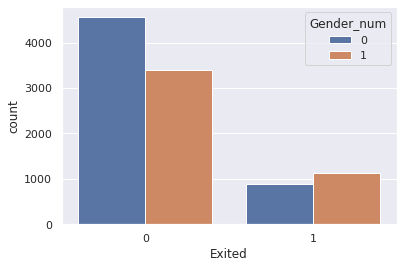

In [ ]:
#Exited e Gender_num - Correlação: 0,11
sns.countplot(x='Exited', hue='Gender_num', data=dados)

Observa-se que o número de clientes mulheres que saem do banco é maior que o número de clientes homens. E também que o banco possui uma maior quantidade de clientes homens.

/usr/local/lib/python3.6/dist-packages/seaborn/axisgrid.py:316: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/axisgrid.py:645: UserWarning: Using the countplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


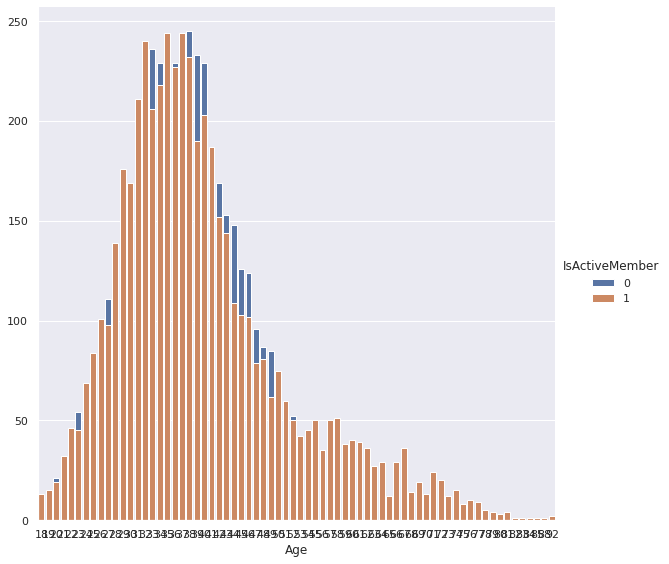

In [ ]:
#IsActiveMember e Age - Correlação: 0,085
g = sns.FacetGrid(dados, hue='IsActiveMember', size=8)
g.map(sns.countplot, 'Age')
g.add_legend()

Observa-se que as duas curvas são bem parecidas, o que demonstra que não tem uma diferença de comportamento com as funções do banco entre os clientes de idades diferentes.

/usr/local/lib/python3.6/dist-packages/seaborn/axisgrid.py:316: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


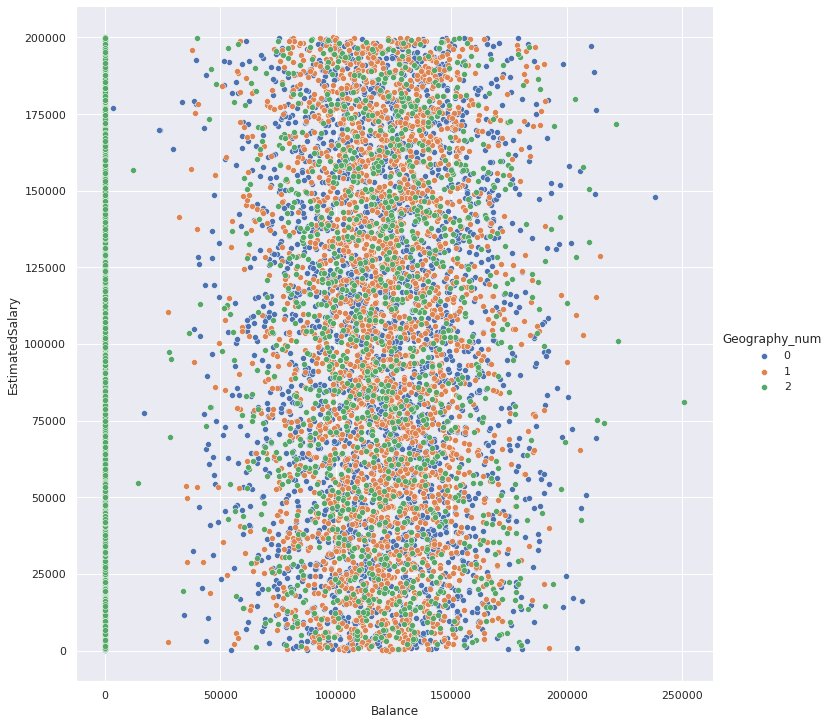

In [ ]:
#Geography_num e Balance - Correlação: 0,069
g = sns.FacetGrid(dados, hue="Geography_num", size=10)
g.map_dataframe(sns.scatterplot, x="Balance", y="EstimatedSalary")
g.set_axis_labels("Balance", "EstimatedSalary")
g.add_legend()

Observa-se no gráfico acima, juntamente com o gráfico de Exited e Balance, que os clientes que sairam do banco com o saldo zero são todos da Espanha.

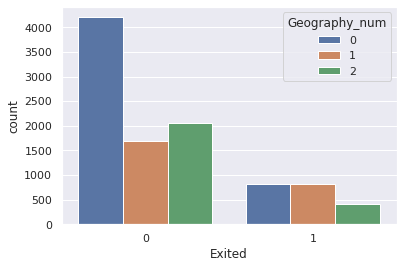

In [ ]:
#Exited e Geography_num - Correlação: 0,036
sns.countplot(x='Exited', hue='Geography_num', data=dados)

Observa-se que o banco tem mais clientes na França, seguido por Espanha e Alemanha. E a quantidade de churn de clientes da França e da Alemanha é a mesma, já a Espanha apresenta um número menor. Comparando com o gráfico anterior, sabe-se que muitos clientes da Espanha sairam com o saldo zerado, já os dos demais países saíram com saldos altos.

# 2. Treinamento e Validação

Serão utilizados dois modelos para tentar classificar o churn de clientes, sendo eles o SVM e o KNN. Porém, antes, a base será dividida ao meio para ser usada separadamente no treino e na validação.

## 2.1. Separando os dados de treino, teste e validação

O dataset possui 10000 dados, assim, 5000 serão usados para treino e 5000 para validação. 

In [ ]:
#Separando a classe dos dados
dados2 = dados.copy()
classes = dados2['Exited']
dados2.drop('Exited', axis=1, inplace=True)

In [ ]:
#Dados para treino e teste
treino = dados2[:-5000]
classes_treino = classes[:-5000]
classes_treino.value_counts()

0    3954
1    1046
Name: Exited, dtype: int64

In [ ]:
#Dados para validação
validacao = dados2[-5000:]
classes_validacao = classes[-5000:]
classes_validacao.value_counts()

0    4009
1     991
Name: Exited, dtype: int64

## 2.2. Modelo SVM

### 2.2.1. Treinamento 

### Aplicando o SVM com os dados divididos pela técnica Holdout

In [ ]:
#Dividindo os dados de treino e teste pela técnica Holdout (80% e 20%)
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(treino, classes_treino, test_size=0.2)

In [ ]:
#Baixando a biblioteca e instanciando o algonitmo SVM
from sklearn import svm
clf = svm.SVC()

In [ ]:
#Treinando o algoritmo SVM
clf.fit(X_train, y_train)

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [ ]:
#Predição dos valores com os dados de teste
predicao_svm = clf.predict(X_test)
predicao_svm

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

### Avaliação dos resultados do treinamento do modelo SVM

Confusion matrix:
 [[783   0]
 [217   0]]


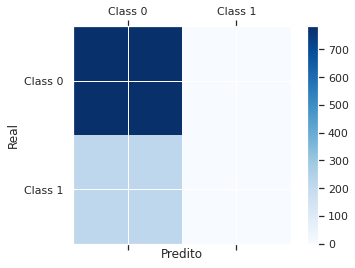

In [ ]:
#Matriz de confusão
from sklearn.metrics import confusion_matrix
conf_mat = confusion_matrix(y_true=y_test, y_pred=predicao_svm)
print('Confusion matrix:\n', conf_mat)

labels = ['Class 0', 'Class 1']
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(conf_mat, cmap=plt.cm.Blues)
fig.colorbar(cax)
ax.set_xticklabels([''] + labels)
ax.set_yticklabels([''] + labels)
plt.xlabel('Predito')
plt.ylabel('Real')
plt.show()

In [ ]:
#Precision, Recall, F1 Score e Accuracy
from sklearn.metrics import classification_report, confusion_matrix
print(classification_report(y_test, predicao_svm))

              precision    recall  f1-score   support

           0       0.78      1.00      0.88       783
           1       0.00      0.00      0.00       217

    accuracy                           0.78      1000
   macro avg       0.39      0.50      0.44      1000
weighted avg       0.61      0.78      0.69      1000



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Observa-se na matriz de confusão, que o modelo classificou todos os dados para a classe 0. Já pelas métricas acima, observa-se que o modelo ficou com uma acurácia de 0.78, o que seria um bom desempenho. Porém, as métricas para a classe 1 estão todas zeradas e é justamente nela que estamos interessados.

Os dados de churn, da mesma forma que os dados de fraudes em cartões de crédito, são desbalanceados. Assim, a acurácia torna-se um mal indicador de desempenho, visto que, a proporção dos números de uma classe são maiores que o da outra, podendo indicar que o modelo está bom, quando na verdade ele não está.

A área sob a curva de recall de precisão (AUPRC) é uma métrica de desempenho útil para dados desequilibrados em uma configuração de problema onde você se preocupa muito em encontrar os exemplos positivos. Essa métrica mede a "precisão média".

Sua linha de base é igual à fração de positivos (exemplos positivos/total exemplos). Isso significa que classes diferentes têm linhas de base AUPRC diferentes. Uma classe com 12% de positivos tem um AUPRC de linha de base de 0,12, portanto, obter um AUPRC de 0,40 nesta classe é ótimo. No entanto, uma classe com 98% de positivos tem um AUPRC de linha de base de 0,98, o que significa que obter um AUPRC de 0,40 nesta classe é ruim. (Fonte: https://glassboxmedicine.com/2019/03/02/measuring-performance-auprc/).

Sendo assim, a seguir será calculada a linha de base e a AUPRC dos dados de teste, para analisar o desempenho do modelo.

In [ ]:
#Contando a quantidade de valores por classe nos dados de teste SVM
y_test.value_counts()

0    783
1    217
Name: Exited, dtype: int64

In [ ]:
#Linha de base AUPRC dos dados de teste SVM
217/(783+217)

0.217

In [ ]:
#AUPRC dos dados de teste do SVM
import sklearn.metrics
auprc_svm_teste = sklearn.metrics.average_precision_score(y_test, predicao_svm)
auprc_svm_teste

0.217

Observa-se que o modelo deu um resultado de AUPRC de 0.217, igual a sua linha de base, não sendo um bom modelo.

### 2.2.2. Lidando com classes desbalanceadas

Para tentar contornar o problema de desbalanceamento das classes, a seguir o modelo será testado novamente após aplicação da técnica undersampling, que consiste em reduzir de forma aleatória os exemplos da classe majoritária, a fim de equalizar. (Fonte: https://medium.com/data-hackers/como-lidar-com-dados-desbalanceados-em-problemas-de-classifica%C3%A7%C3%A3o-17c4d4357ef9)


### Undersampling

In [ ]:
dados3 = dados.copy()
dados_balan = dados3[:-5000] #mesma quantidade dos dados de treino

#Contando as classificações
count_class_0, count_class_1 = dados_balan.Exited.value_counts()

#Dividindo o dataframe por classificação
dados_class_0 = dados_balan[dados_balan['Exited'] == 0]
dados_class_1 = dados_balan[dados_balan['Exited'] == 1]

Random under-sampling:
1    1046
0    1046
Name: Exited, dtype: int64


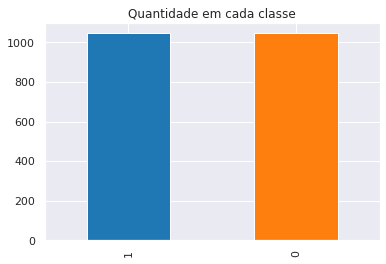

In [ ]:
#Equalizando a base por undersampling
dados_class_0_under = dados_class_0.sample(count_class_1)
dados_test_under = pd.concat([dados_class_0_under, dados_class_1], axis=0)

print('Random under-sampling:')
print(dados_test_under.Exited.value_counts())

dados_test_under.Exited.value_counts().plot(kind='bar', title='Quantidade em cada classe',color = ['#1F77B4', '#FF7F0E']);

In [ ]:
classes_under = dados_test_under['Exited']
dados_test_under.drop('Exited', axis=1, inplace=True)

### Treinando o modelo SVM após Undersampling

In [ ]:
#Treinando o algoritmo SVM
clf.fit(dados_test_under, classes_under)

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [ ]:
#Predição dos valores com os dados de teste
predicao_svm_under = clf.predict(X_test)

### Avaliação dos resultados do treinamento do modelo SVM após Undersampling

Confusion matrix:
 [[288 495]
 [ 60 157]]


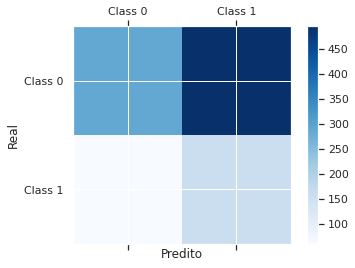

In [ ]:
#Matriz de confusão
conf_mat = confusion_matrix(y_true=y_test, y_pred=predicao_svm_under)
print('Confusion matrix:\n', conf_mat)

labels = ['Class 0', 'Class 1']
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(conf_mat, cmap=plt.cm.Blues)
fig.colorbar(cax)
ax.set_xticklabels([''] + labels)
ax.set_yticklabels([''] + labels)
plt.xlabel('Predito')
plt.ylabel('Real')
plt.show()

In [ ]:
#Precision, Recall, F1 Score e Accuracy
print(classification_report(y_test, predicao_svm_under))

              precision    recall  f1-score   support

           0       0.83      0.37      0.51       783
           1       0.24      0.72      0.36       217

    accuracy                           0.45      1000
   macro avg       0.53      0.55      0.44      1000
weighted avg       0.70      0.45      0.48      1000



In [ ]:
#AUPRC dos dados de teste do SVM após undersampling
auprc_svm_under = sklearn.metrics.average_precision_score(y_test, predicao_svm_under)
auprc_svm_under

0.2342175793729326

Observa-se pelos resultados após a undersampling que:
* a acurácia do modelo diminuiu de 0.78 para 0.45;
* as métricas da classe 1 deixaram de ser zero, porém ainda representam valores ruins de precisão e recall;
* a AUPRC aumentou de 0.217 para 0.234, porém ainda indica um desempenho ruim.

### 2.2.3. Validação

A validação vai ocorrer de duas formas:
1. Será rodado o modelo com os dados de validação, calculando a matriz de confusão, as métricas (Precision, Recall, F1 Score e Accuracy) e a AUPRC;
2. Será realizada uma cross validation também nos dados de validação e calculada as métricas; e
3. Comparação dos resultados e avaliação geral do modelo. 

In [ ]:
#Predição dos valores com os dados de validação
predicao_val_svm = clf.predict(validacao)
predicao_val_svm

array([1, 0, 1, ..., 0, 1, 1])

Confusion matrix:
 [[1619 2390]
 [ 231  760]]


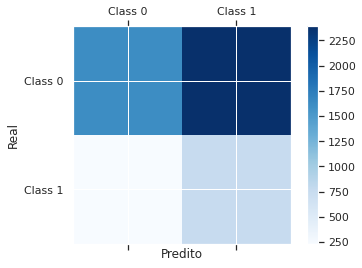

In [ ]:
#Matriz de confusão
conf_mat = confusion_matrix(y_true=classes_validacao, y_pred=predicao_val_svm)
print('Confusion matrix:\n', conf_mat)

labels = ['Class 0', 'Class 1']
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(conf_mat, cmap=plt.cm.Blues)
fig.colorbar(cax)
ax.set_xticklabels([''] + labels)
ax.set_yticklabels([''] + labels)
plt.xlabel('Predito')
plt.ylabel('Real')
plt.show()

In [ ]:
#Precision, Recall, F1 Score e Accuracy
print(classification_report(classes_validacao, predicao_val_svm))

              precision    recall  f1-score   support

           0       0.88      0.40      0.55      4009
           1       0.24      0.77      0.37       991

    accuracy                           0.48      5000
   macro avg       0.56      0.59      0.46      5000
weighted avg       0.75      0.48      0.52      5000



In [ ]:
#AUPRC dos dados de validacao do SVM
auprc_svm_validacao = sklearn.metrics.average_precision_score(classes_validacao, predicao_val_svm)
auprc_svm_validacao

0.23123035253792065

Observa-se pelos resultados da validação que:

* a acurácia do modelo aumentou de 0.45 para 0.48; e
* as métricas da classe 1 e a AUPRC não alteraram muito.

### Cross Validation

In [ ]:
#Cross validation e métricas com os dados de validação do SVM
from sklearn.model_selection import cross_val_predict
from sklearn import metrics
resultados_svm = cross_val_predict(clf,validacao, classes_validacao, cv=5)
valor_classes = [0,1]
print (metrics.classification_report(classes_validacao,resultados_svm,valor_classes))

              precision    recall  f1-score   support

           0       0.80      1.00      0.89      4009
           1       0.00      0.00      0.00       991

    accuracy                           0.80      5000
   macro avg       0.40      0.50      0.44      5000
weighted avg       0.64      0.80      0.71      5000



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Os resultados após a cross validation, apesar da acurácia ser igual a 0.80, continuam com os mesmos problemas identificados no primeiro treinamento. Assim, apesar da tentativa de balanceamento das classes para treinamento do modelo SVM, ele não conseguiu um bom desempenho para esse problema de churn.

## 2.3. Modelo KNN

### 2.3.1. Treinamento

### Aplicando o KNN com os dados divididos pela técnica Holdout

In [ ]:
#Dividindo os dados de treino e teste pela técnica Holdout (80% e 20%)
X_train, X_test, y_train, y_test = train_test_split(treino, classes_treino, test_size=0.2)

In [ ]:
#Baixando a biblioteca e instanciando o algonitmo KNN
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors=2)

In [ ]:
#Treinando o algoritmo KNN
knn.fit(X_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=2, p=2,
                     weights='uniform')

In [ ]:
#Predição dos valores com os dados de teste do KNN
predicao_knn = knn.predict(X_test)
predicao_knn

array([0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

### Avaliação dos resultados do treinamento do modelo KNN

Confusion matrix:
 [[767  36]
 [186  11]]


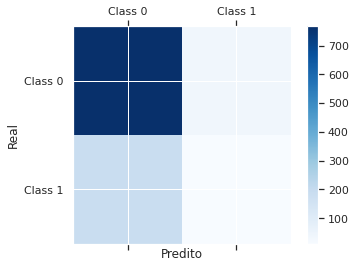

In [ ]:
#Matriz de confusão
conf_mat = confusion_matrix(y_true=y_test, y_pred=predicao_knn)
print('Confusion matrix:\n', conf_mat)

labels = ['Class 0', 'Class 1']
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(conf_mat, cmap=plt.cm.Blues)
fig.colorbar(cax)
ax.set_xticklabels([''] + labels)
ax.set_yticklabels([''] + labels)
plt.xlabel('Predito')
plt.ylabel('Real')
plt.show()

In [ ]:
#Precision, Recall, F1 Score e Accuracy
print(classification_report(y_test, predicao_knn))

              precision    recall  f1-score   support

           0       0.80      0.96      0.87       803
           1       0.23      0.06      0.09       197

    accuracy                           0.78      1000
   macro avg       0.52      0.51      0.48      1000
weighted avg       0.69      0.78      0.72      1000



In [ ]:
#Contando a quantidade de valores por classe nos dados de teste KNN
y_test.value_counts()

0    803
1    197
Name: Exited, dtype: int64

In [ ]:
#Linha de base AUPRC dos dados de teste KNN
197/(803+197)

0.197

In [ ]:
#AUPRC dos dados de teste do KNN
auprc_knn = sklearn.metrics.average_precision_score(y_test, predicao_knn)
auprc_knn

0.1990683659142456

Observa-se que, comparado aos resultados de treinamento do SVM, nos do KNN:
* a matriz de confusão e as métricas para a classe 1 não ficaram zeradas;
* a acurácia ficou só igual a obtida no primeiro teste do SVM; e
* a AUPRC também ficou muito próxima da sua linha de base.

### Treinando o modelo KNN com os dados balanceados pela Undersampling

In [ ]:
#Treinando o algoritmo KNN
knn.fit(dados_test_under, classes_under)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=2, p=2,
                     weights='uniform')

In [ ]:
#Predição dos valores com os dados de teste do KNN
predicao_knn_under = knn.predict(X_test)
predicao_knn_under

array([0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1,
       0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0,
       0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1,
       0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1,
       1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1,
       0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0,
       1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1,
       1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0,

### Avaliação dos resultados do treinamento do modelo KNN após Undersampling

Confusion matrix:
 [[655 148]
 [102  95]]


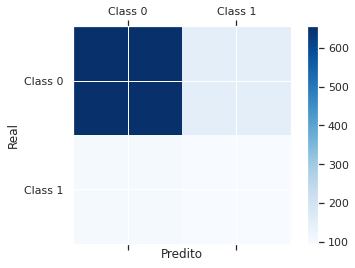

In [ ]:
#Matriz de confusão
conf_mat = confusion_matrix(y_true=y_test, y_pred=predicao_knn_under)
print('Confusion matrix:\n', conf_mat)

labels = ['Class 0', 'Class 1']
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(conf_mat, cmap=plt.cm.Blues)
fig.colorbar(cax)
ax.set_xticklabels([''] + labels)
ax.set_yticklabels([''] + labels)
plt.xlabel('Predito')
plt.ylabel('Real')
plt.show()

In [ ]:
#Precision, Recall, F1 Score e Accuracy
print(classification_report(y_test, predicao_knn_under))

              precision    recall  f1-score   support

           0       0.87      0.82      0.84       803
           1       0.39      0.48      0.43       197

    accuracy                           0.75      1000
   macro avg       0.63      0.65      0.64      1000
weighted avg       0.77      0.75      0.76      1000



In [ ]:
#AUPRC dos dados de teste do KNN após undersampling
auprc_knn_under = sklearn.metrics.average_precision_score(y_test, predicao_knn_under)
auprc_knn_under

0.29052750099225

Observa-se pelos resultados após a undersampling que:
* a acurácia do modelo diminui;
* as métricas da classe 1 aumentaram;
* a AUPRC aumentou de 0.1990 para 0.2905, o que representa uma melhora em relação ao resultado obtido no primeiro teste e também pelo SVM.

### 2.3.2. Validação

In [ ]:
#Predição dos valores com os dados de teste
predicao_val_knn = knn.predict(validacao)
predicao_val_knn

array([0, 0, 0, ..., 0, 0, 1])

Confusion matrix:
 [[3055  954]
 [ 721  270]]


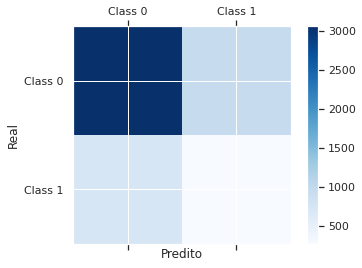

In [ ]:
#Matriz de confusão
conf_mat = confusion_matrix(y_true=classes_validacao, y_pred=predicao_val_knn)
print('Confusion matrix:\n', conf_mat)

labels = ['Class 0', 'Class 1']
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(conf_mat, cmap=plt.cm.Blues)
fig.colorbar(cax)
ax.set_xticklabels([''] + labels)
ax.set_yticklabels([''] + labels)
plt.xlabel('Predito')
plt.ylabel('Real')
plt.show()

In [ ]:
#Precision, Recall, F1 Score e Accuracy
print(classification_report(classes_validacao, predicao_val_knn))

              precision    recall  f1-score   support

           0       0.81      0.76      0.78      4009
           1       0.22      0.27      0.24       991

    accuracy                           0.67      5000
   macro avg       0.51      0.52      0.51      5000
weighted avg       0.69      0.67      0.68      5000



In [ ]:
#AUPRC dos dados de validação do KNN
auprc_knn_validacao = sklearn.metrics.average_precision_score(classes_validacao, predicao_val_knn)
auprc_knn_validacao

0.20429972101857896

Observa-se pelos resultados da validação que:

* a acurácia do modelo diminuiu de 0.75 para 0.67; e
* as métricas da classe 1 e a AUPRC também reduziram em relação as obtidas no treinamento.

### Cross validation

In [ ]:
#Cross validation e métricas com os dados de validação do KNN
from sklearn.model_selection import cross_val_predict
from sklearn import metrics
resultados_knn = cross_val_predict(knn,validacao, classes_validacao, cv=5)
valor_classes = [0,1]
print (metrics.classification_report(classes_validacao,resultados_knn,valor_classes))

              precision    recall  f1-score   support

           0       0.80      0.96      0.88      4009
           1       0.23      0.05      0.08       991

    accuracy                           0.78      5000
   macro avg       0.52      0.50      0.48      5000
weighted avg       0.69      0.78      0.72      5000



Observa-se nos resultados após a cross validation do KNN, que em comparação ao modelo SVM, ele apresentou uma acurácia 0.02 menor, porém as métricas da classe 1 não ficaram zeradas. Assim, apesar do desempenho não ter sido muito bom, com esse algoritmo foi possível classificar de alguma forma a classe 1.

# 3. Conclusões

O objetivo desse projeto era propor um modelo capaz de classificar o churn de clientes. Comparando os resultados obtidos na validação dos dois modelos analisados, em relação a matriz de confusão observa-se que o SVM acertou a classificação de um número maior de dados para a classe 1 em comparação com o KNN, porém, ele também errou mais a classificação da classe 0. Por outro lado, o KNN, apesar de ter classicado menos dados corretos na classe 1, teve mais acertos somando o Verdadeiro Positivo e o Verdadeiro Negativo.Já em relação aos resultados obtidos após a cross validation, o KNN também se saiu melhor, porque ele apresentou métricas positivas para a classe 1, enquanto no SVM todas foram igual a zero.

De forma geral, o fato dos dados serem desbalanceados parece ter prejudicado bastante os modelos, talvez seja necessário aplicar técnicas mais avançadas de balanceamento. A quantidade de dados disponíveis também pode ter influenciado os resultados, talvez com uma base maior seja possível fazer um treinamento mais adequado. Por fim, os dois modelos não tiveram um desempenho confiável, mas o KNN se saiu melhor na classificação. 

